In [ ]:
# Eliminar el archivo paintings.csv
!rm paintings.csv

# Eliminar la carpeta wikiart_images y su contenido
!rm -r wikiart_images

In [ ]:
import requests
from bs4 import BeautifulSoup
import csv

def scrape_wikiart_names(artist_url, author_name):
    url = f"https://www.wikiart.org/en/{artist_url}/all-works/text-list"
    response = requests.get(url)

    soup = BeautifulSoup(response.text, 'html.parser')
    paintings = soup.find_all('li', class_='painting-list-text-row')

    # Abrir el archivo en modo "agregar" ('a') para no sobrescribir los datos existentes
    with open('paintings.csv', mode='a', newline='') as file:
        writer = csv.writer(file)

        # Verificar si el archivo está vacío para escribir el encabezado solo una vez
        if file.tell() == 0:
            writer.writerow(["Author", "Painting Name", "URL"])  # Encabezados solo si el archivo está vacío

        for painting in paintings:
            painting_name = painting.find('a').text.strip()  # Obtener el nombre de la obra y quitar espacios en blanco
            img_page = painting.find('a')['href']
            writer.writerow([author_name, painting_name, f"https://www.wikiart.org{img_page}"])
            #print(f"Autor: {author_name}, Obra: {painting_name}")

# Ejemplo para obtener los datos de las obras de varios artistas
scrape_wikiart_names("vincent-van-gogh", "Vincent van Gogh")
scrape_wikiart_names("pablo-picasso", "Pablo Picasso")
scrape_wikiart_names("leonardo-da-vinci", "Leonardo da Vinci")
scrape_wikiart_names("claude-monet", "Claude Monet")
scrape_wikiart_names("salvador-dali", "Salvador Dali")
scrape_wikiart_names("frida-kahlo", "Frida Kahlo")

In [ ]:
import os
import pandas as pd
import requests
from concurrent.futures import ThreadPoolExecutor
from bs4 import BeautifulSoup

# Lee el archivo CSV
df = pd.read_csv('paintings.csv')

# Crear la carpeta principal 'wikiart_images' si no existe
save_dir = 'wikiart_images'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Función para obtener la URL de la imagen
def get_image_url(page_url):
    try:
        response = requests.get(page_url)
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, 'html.parser')
            img_tag = soup.find('img', itemprop='image')
            if img_tag and 'src' in img_tag.attrs:
                return img_tag['src'].replace(':large', '')
        else:
            print(f"Error al acceder a {page_url}: {response.status_code}")
    except Exception as e:
        print(f"Error al acceder a {page_url}: {e}")
    return None

# Función para descargar imágenes
def download_image(row):
    # Obtener el nombre del autor y de la obra
    author = row['Author'].replace(' ', '_').replace('/', '_')  # Limpiar el nombre del autor
    painting_name = row['Painting Name'].replace(' ', '_').replace('/', '_')  # Limpiar el nombre de la obra

    # Crear una carpeta para el autor dentro de 'wikiart_images'
    author_dir = os.path.join(save_dir, author)
    os.makedirs(author_dir, exist_ok=True)  # Esto asegura que no haya error si la carpeta ya existe (Sirve para un entorno con múltiple hilos)

    # Obtener la URL de la imagen
    image_url = get_image_url(row['URL'])
    if image_url:  # Verifica que la URL de la imagen no sea None
        # Generar el nombre del archivo usando el nombre de la obra
        image_name = f"{painting_name}.jpg"

        try:
            response = requests.get(image_url)
            if response.status_code == 200:
                # Guardar la imagen en la carpeta del autor
                with open(os.path.join(author_dir, image_name), 'wb') as f:
                    f.write(response.content)
                print(f"Descargada: {os.path.join(author_dir, image_name)}")
            else:
                print(f"Error al descargar {image_name}: {response.status_code}")
        except Exception as e:
            print(f"Error al descargar {image_name}: {e}")
    else:
        print(f"No se pudo obtener la URL de la imagen para {painting_name}")

# Descargar las imágenes usando múltiples hilos
with ThreadPoolExecutor(max_workers=10) as executor:  # max_workers determina cuántas descargas en paralelo
    # Pasar cada fila del DataFrame para la descarga
    futures = [executor.submit(download_image, row) for _, row in df.iterrows()]

    # Verificar la finalización de las tareas
    for future in futures:
        future.result()

Se han truncado las últimas 5000 líneas del flujo de salida.
Descargada: wikiart_images/Vincent_van_Gogh/The_Fourteenth_of_July_Celebration_in_Paris.jpg
Descargada: wikiart_images/Vincent_van_Gogh/The_Bois_de_Boulogne_with_People_Walking.jpg
Descargada: wikiart_images/Vincent_van_Gogh/Terrace_of_a_Cafe_on_Montmartre_"La_Guinguette".jpg
Descargada: wikiart_images/Vincent_van_Gogh/The_Green_Parrot.jpg
Descargada: wikiart_images/Vincent_van_Gogh/The_Hill_of_Montmartre_with_Quarry.jpg
Descargada: wikiart_images/Vincent_van_Gogh/The_Mill_of_Blute_End.jpg
Descargada: wikiart_images/Vincent_van_Gogh/The_Kingfisher.jpg
Descargada: wikiart_images/Vincent_van_Gogh/The_Moulin_de_la_Galette.jpg
Descargada: wikiart_images/Vincent_van_Gogh/The_Outskirts_of_Paris.jpg
Descargada: wikiart_images/Vincent_van_Gogh/The_Pont_du_Carrousel_and_the_Louvre.jpg
Descargada: wikiart_images/Vincent_van_Gogh/The_Roofs_of_Paris.jpg
Descargada: wikiart_images/Vincent_van_Gogh/The_Roofs_of_Paris_and_Notre-Dame.jpg
Des

In [ ]:
import numpy as np
import cv2
import os

def load_images_from_folder(folder):
    images = []
    labels = []
    # Recorrer todas las subcarpetas en el directorio principal
    for subfolder in os.listdir(folder):
        subfolder_path = os.path.join(folder, subfolder)
        if os.path.isdir(subfolder_path):  # Verificar que sea un directorio
            # Recorrer todas las imágenes en la subcarpeta
            for filename in os.listdir(subfolder_path):
                img_path = os.path.join(subfolder_path, filename)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, (244, 244))  # Redimensionar a 224x224 para MobileNetV2
                    images.append(img)
                    labels.append(subfolder)  # Usar el nombre de la subcarpeta como etiqueta
    return images, labels

# Ejemplo de uso
images, labels = load_images_from_folder('wikiart_images')

print(f"Total de imágenes cargadas: {len(images)}")
print(f"Total de etiquetas cargadas: {len(labels)}")

print("Primeras etiquetas:", labels[:10])  # Mostrar las primeras 10 etiquetas para verificar

Total de imágenes cargadas: 5024
Total de etiquetas cargadas: 5024
Primeras etiquetas: ['Frida_Kahlo', 'Frida_Kahlo', 'Frida_Kahlo', 'Frida_Kahlo', 'Frida_Kahlo', 'Frida_Kahlo', 'Frida_Kahlo', 'Frida_Kahlo', 'Frida_Kahlo', 'Frida_Kahlo']


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Crear un generador de datos con aumentación que simula condiciones típicas de fotos de celulares
datagen = ImageDataGenerator(
    rotation_range=15,          # Rotaciones pequeñas (0-15 grados)
    width_shift_range=0.1,      # Desplazamiento horizontal menor
    height_shift_range=0.1,     # Desplazamiento vertical menor
    zoom_range=0.1,             # Zoom aleatorio pequeño
    brightness_range=[0.9, 1.1],# Ajuste de brillo (más oscuro o más claro)
    horizontal_flip=True,       # Voltear horizontalmente
    rescale=1/255.0,            # Normalizar los píxeles
    fill_mode='nearest'         # Modo de relleno para áreas vacías
)

# Configurar el flujo de datos desde el directorio
train_generator = datagen.flow_from_directory(
    'wikiart_images',          # Directorio principal con subcarpetas de autores
    target_size=(224, 224),    # Tamaño de entrada esperado por MobileNetV2
    batch_size=32,             # Tamaño del batch
    class_mode='categorical',  # Clasificación multiclase
    shuffle=True               # Activar el shuffle
)

Found 5027 images belonging to 6 classes.


In [ ]:
for batch in train_generator:
    print(f"Tamaño del lote: {len(batch[0])}")  # Verifica el tamaño de cada lote
    break

print(f"Total de imágenes en el generador: {train_generator.samples}")
print(f"Tamaño del batch: {train_generator.batch_size}")
print(f"Clases encontradas: {train_generator.class_indices}")

for batch_images, batch_labels in train_generator:
    print(f"Tamaño del lote: {len(batch_images)}")
    break  # Solo para mostrar un lote y no iterar indefinidamente

Tamaño del lote: 32
Total de imágenes en el generador: 5027
Tamaño del batch: 32
Clases encontradas: {'Claude_Monet': 0, 'Frida_Kahlo': 1, 'Leonardo_da_Vinci': 2, 'Pablo_Picasso': 3, 'Salvador_Dali': 4, 'Vincent_van_Gogh': 5}
Tamaño del lote: 32


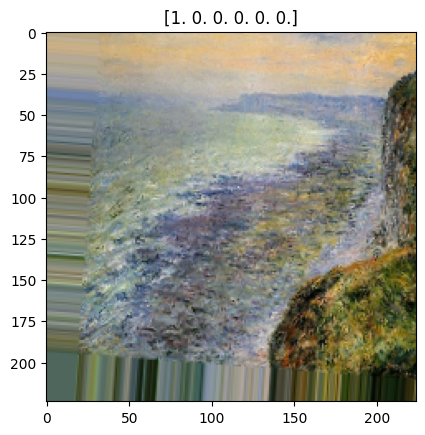

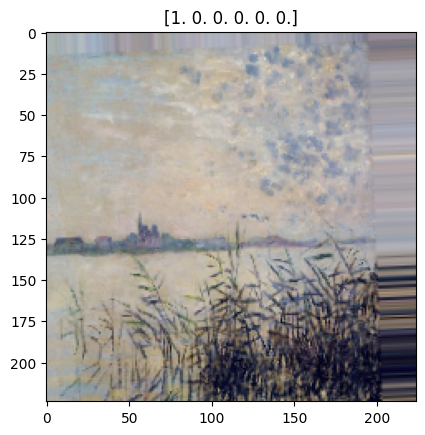

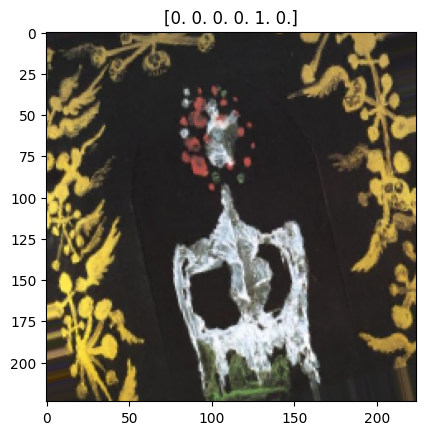

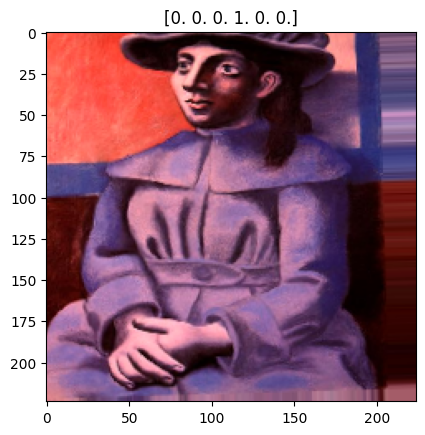

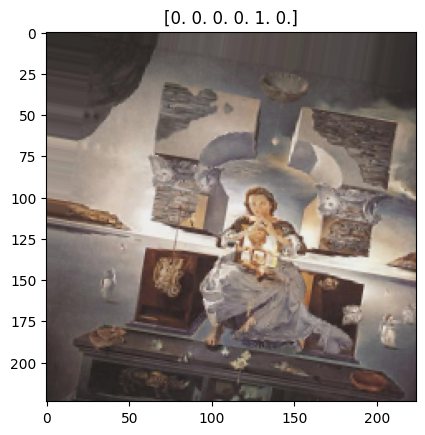

In [ ]:
import matplotlib.pyplot as plt

batch = next(train_generator)  # Obtener un lote
images, labels = batch
for i in range(5):  # Mostrar 5 imágenes
    plt.imshow(images[i])
    plt.title(labels[i])
    plt.show()

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Crear el modelo base de MobileNetV2 (sin las capas superiores)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Añadir una capa de pooling global y una capa densa
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Reduce la dimensionalidad
x = Dense(512, activation='relu')(x)  # Capa densa con menos unidades

# Obtener el número de clases directamente desde el generador
num_classes = train_generator.num_classes
predictions = Dense(num_classes, activation='softmax')(x)  # Capa de salida

# Definir el modelo final
model = Model(inputs=base_model.input, outputs=predictions)

# Congelar las capas del modelo base
for layer in base_model.layers:
    layer.trainable = False

# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Configurar el callback para reducir la tasa de aprendizaje
reduce_lr = ReduceLROnPlateau(
    monitor='loss',  # Puedes usar 'val_loss' si tienes un conjunto de validación
    factor=0.5,      # Factor por el cual la tasa de aprendizaje se reducirá
    patience=2,      # Número de épocas sin mejora antes de reducir la tasa
    min_lr=1e-6      # Límite inferior para la tasa de aprendizaje
)

In [ ]:
# Entrenar el modelo utilizando el generador
model.fit(
    train_generator,
    epochs=7,
    steps_per_epoch=min(100, train_generator.samples // train_generator.batch_size), # Ajusta el número de pasos
    #steps_per_epoch = max(1, (train_generator.samples // train_generator.batch_size) - 1), #Por si la cantidad de img no es divisible entre el tamaño del batch
    #steps_per_epoch = train_generator.samples // train_generator.batch_size,
    callbacks=[reduce_lr]
)

Epoch 1/7


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 63s 480ms/step - accuracy: 0.5949 - loss: 1.3179 - learning_rate: 0.0010
Epoch 2/7
100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 268ms/step - accuracy: 0.7793 - loss: 0.6416 - learning_rate: 0.0010
Epoch 3/7


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


100/100 ━━━━━━━━━━━━━━━━━━━━ 50s 473ms/step - accuracy: 0.7752 - loss: 0.5811 - learning_rate: 0.0010
Epoch 4/7
100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 242ms/step - accuracy: 0.8348 - loss: 0.4827 - learning_rate: 0.0010
Epoch 5/7
100/100 ━━━━━━━━━━━━━━━━━━━━ 50s 472ms/step - accuracy: 0.8250 - loss: 0.5077 - learning_rate: 0.0010
Epoch 6/7
100/100 ━━━━━━━━━━━━━━━━━━━━ 25s 253ms/step - accuracy: 0.8435 - loss: 0.4582 - learning_rate: 0.0010
Epoch 7/7
100/100 ━━━━━━━━━━━━━━━━━━━━ 57s 465ms/step - accuracy: 0.8504 - loss: 0.4012 - learning_rate: 0.0010


In [ ]:
# Ahora, hacer fine-tuning de las últimas capas convolucionales de InceptionV3
# Descongelar las últimas capas convolucionales
for layer in model.layers[:20]:
    layer.trainable = False
for layer in model.layers[20:]:
    layer.trainable = True

# Recompilar el modelo con un optimizador SGD de baja tasa de aprendizaje
from keras.optimizers import SGD
model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',  # O 'loss' si no tienes un conjunto de validación
    patience=3,          # Número de épocas sin mejora antes de detener el entrenamiento
    restore_best_weights=True
)

In [ ]:
# Entrenar nuevamente con las capas descongeladas
model.fit(
    train_generator,
    epochs=30,
    steps_per_epoch=min(100, train_generator.samples // train_generator.batch_size),
    #steps_per_epoch = max(1, (train_generator.samples // train_generator.batch_size) - 1),
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 82s 514ms/step - accuracy: 0.6947 - loss: 0.8312 - learning_rate: 1.0000e-04
Epoch 2/30


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate
  current = self.get_monitor_value(logs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 39s 389ms/step - accuracy: 0.7980 - loss: 0.5500 - learning_rate: 1.0000e-04
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 85s 495ms/step - accuracy: 0.8320 - loss: 0.4854 - learning_rate: 1.0000e-04
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 25s 253ms/step - accuracy: 0.8389 - loss: 0.4647 - learning_rate: 1.0000e-04
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 52s 495ms/step - accuracy: 0.8507 - loss: 0.4611 - learning_rate: 1.0000e-04
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 25s 253ms/step - accuracy: 0.8616 - loss: 0.4312 - learning_rate: 1.0000e-04
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 53s 501ms/step - accuracy: 0.8426 - loss: 0.4242 - learning_rate: 1.0000e-04
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 255ms/step - accuracy: 0.8615 - loss: 0.4079 - learning_rate: 1.0000e-04
Epoch 9/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 56s 492ms/step - accuracy: 0.8741 - loss: 0.3773 - learning_rate: 1.0000e-04
Epoch 10/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 25s 250ms/step - accuracy: 0.8731 


# Test con link

In [ ]:
import tensorflow as tf
import requests
from io import BytesIO
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# URL de la imagen a probar
url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcR_9w-ox66VzF6_iIQW8fUmJaG0i9pTvpDAKQ&s'

# Descargar la imagen desde la URL
response = requests.get(url)

# Verificar si la respuesta es una imagen
if 'image' in response.headers['Content-Type']:
    # Redimensionar a 224x224 para MobileNetV2
    img = load_img(BytesIO(response.content), target_size=(224, 224))
    img = img_to_array(img) / 244.0  # Normalización al rango [0, 1]
    img = np.expand_dims(img, axis=0)  # Añadir dimensión de batch

    # Hacer predicción con el modelo cargado
    predictions = model.predict(img)

    # Obtener la clase predicha y la confianza
    predicted_class = np.argmax(predictions, axis=1)[0]
    confidence = predictions[0][predicted_class]

    # Invertir el mapeo class_indices para obtener el nombre del autor
    class_labels = {v: k for k, v in train_generator.class_indices.items()}

    # Verificar si la confianza es menor al 75%
    if confidence < 0.75:
        print("La clase predicha es: Desconocido")
        print(f"Confianza: {confidence * 100:.2f}% (por debajo del umbral)")
    else:
        predicted_label = class_labels[predicted_class]
        print(f"La clase predicha es: {predicted_label}")
        print(f"Confianza: {confidence * 100:.2f}%")
else:
    print("La URL no apunta a una imagen válida.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
La clase predicha es: Desconocido
Confianza: 42.37% (por debajo del umbral)


In [ ]:
import tensorflow as tf

# Convertir el modelo Keras a TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
# Opcional: habilitar optimizaciones para reducir el tamaño del modelo
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Aplicar cuantización dinámica
converter.target_spec.supported_types = [tf.float16]
tflite_model = converter.convert()

# Guardar el modelo convertido en un archivo .tflite
with open('modelo_entrenado_mejorado.tflite', 'wb') as f:
    f.write(tflite_model)

print("Modelo exportado a modelo_entrenado_mejorado.tflite")

Saved artifact at '/tmp/tmppn080d_q'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  137258055698912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137258056111680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137258056107280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137256470918976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137258056112208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137258054193344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137258054200032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137258054204080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137258054191056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137258054199856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13725805616435

In [ ]:
interpreter = tf.lite.Interpreter(model_path='modelo_entrenado_mejorado.tflite', experimental_delegates=[])
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(f"Detalles de entrada: {input_details}")
print(f"Detalles de salida: {output_details}")

Detalles de entrada: [{'name': 'serving_default_keras_tensor:0', 'index': 0, 'shape': array([  1, 224, 224,   3], dtype=int32), 'shape_signature': array([ -1, 224, 224,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Detalles de salida: [{'name': 'StatefulPartitionedCall_1:0', 'index': 288, 'shape': array([1, 6], dtype=int32), 'shape_signature': array([-1,  6], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
